In [ ]:
!pip install datasets matplotlib pandas sentence_transformers

In [2]:
from datasets import load_dataset, concatenate_datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from  sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers import InputExample


/Users/konstantinspiess/miniconda3/envs/nlp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# STS12-STS16, STSbenchmark, SICKr

## Dataset Analysis

In [3]:
# Load STS datasets
sts12 = load_dataset("mteb/sts12-sts")
sts13 = load_dataset("mteb/sts13-sts")
sts14 = load_dataset("mteb/sts14-sts")
sts15 = load_dataset("mteb/sts15-sts")
sts16 = load_dataset("mteb/sts16-sts")
stsb = load_dataset("mteb/stsbenchmark-sts")
sickr = load_dataset("mteb/sickr-sts")

# Combine datasets into one
sts12_test = sts12["test"]
sts13_test = sts13["test"]
sts14_test = sts14["test"]
sts15_test = sts15["test"]
sts16_test = sts16["test"]
stsb_validation = stsb["validation"]
stsb_test = stsb["test"]
sickr_test = sickr["test"]

dataset = concatenate_datasets([sts12_test, sts13_test, sts14_test, sts15_test, sts16_test, stsb_validation, stsb_test, sickr_test])

/Users/malte/miniconda3/envs/embenchmark2/lib/python3.9/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


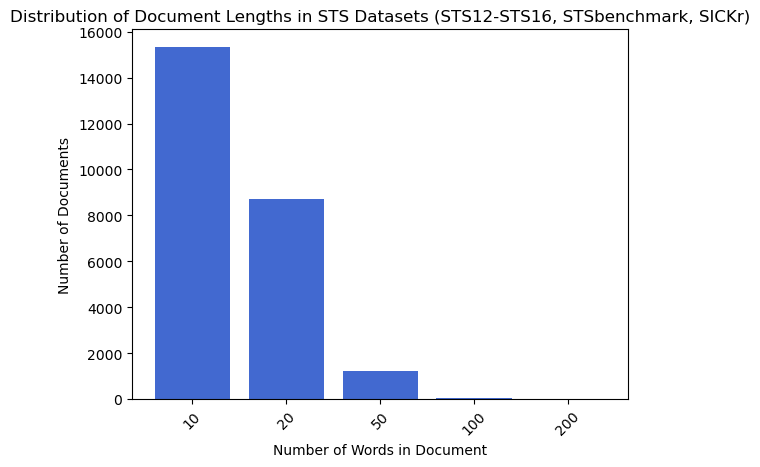

In [4]:
word_count = [len(doc.split()) for doc in dataset['sentence1']]

bins = [0, 10, 20, 50, 100, 200]
bin_labels = ["10", "20", "50", "100", "200"]

bin_values = []
for i in range(len(bins) - 1):
    bin_values.append(sum([1 for count in word_count if bins[i] < count <= bins[i + 1]]))

# Data for plotting
bins = bin_labels
counts = bin_values

plt.bar(bins, counts, color="#4269D0")
plt.xlabel('Number of Words in Document')
plt.ylabel('Number of Documents')
plt.title('Distribution of Document Lengths in STS Datasets (STS12-STS16, STSbenchmark, SICKr)')
plt.xticks(rotation=45)

plt.rcParams["font.family"] = "Inter"
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", [ "#4269D0","#3BA951", "#EFB117", "#FF725C"])

# higher resolution output without saving the file
plt.savefig('plots/sts/sts_distribution.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


# STS22

## Dataset Analysis

In [5]:
subsets = [
  "all_languages",
  "ar",
  "de",
  "de-en",
  "de-fr",
  "de-pl",
  "en",
  "es",
  "es-en",
  "es-it",
  "fr",
  "fr-pl",
  "it",
  "pl",
  "pl-en",
  "ru",
  "tr",
  "zh",
  "zh-en"
]

sts22 = {}

for subset in subsets:
  sts22[subset] = load_dataset("mteb/sts22-crosslingual-sts", subset, split="test")

In [7]:
def createPlts(datasets, datasetKeys: list[str], bins: list[int], filename: str):
    word_count = {}
    for i in datasetKeys:
        word_count[i] = [len(x.split()) for x in datasets[i]["sentence1"]]

    num_subplots = len(datasetKeys)
    num_cols = 7
    num_rows = num_subplots // num_cols + (num_subplots % num_cols > 0)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))
    axes = axes.flatten()

    # Updated bin labels
    bin_labels = [str(bins[i+1]) for i in range(len(bins)-1)]

    for idx, subset in enumerate(datasetKeys):
        data = word_count[subset]

        # Calculate bin_values
        bin_values = []
        for i in range(len(bins) - 1):
            bin_values.append(sum([1 for count in data if bins[i] < count <= bins[i + 1]]))

        # Plotting the bar chart
        axes[idx].bar(bin_labels, bin_values, color="#4269D0")
        axes[idx].set_title("STS22: " + subset + " Distribution of Text Lengths")
        axes[idx].set_xlabel('Words per Text')
        axes[idx].set_ylabel('Frequency')
        axes[idx].tick_params(axis='x', rotation=45)

        # Setting y-axis limits based on the maximum bin value
        max_count = max(bin_values)
        ylims = [200, 500, 1000, 1500]
        ylim = next((y for y in ylims if y >= max_count), 2000)
        axes[idx].set_ylim(0, ylim)

    # Remove extra subplots
    for i in range(num_subplots, num_rows * num_cols):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


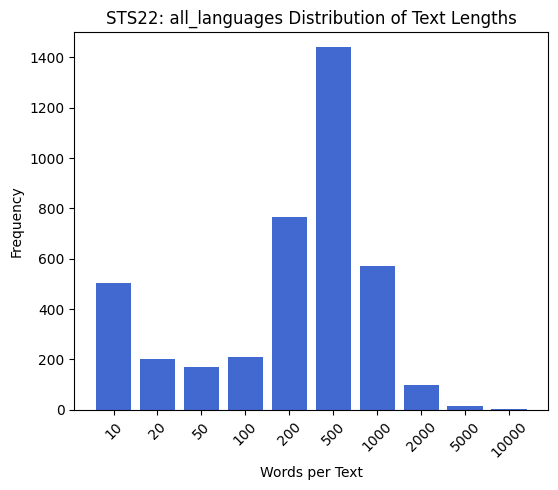

In [8]:
BINS = [0, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
SUBSETS = ["all_languages"]
createPlts(sts22, SUBSETS, BINS, "plots/sts/sts22_distribution.png")

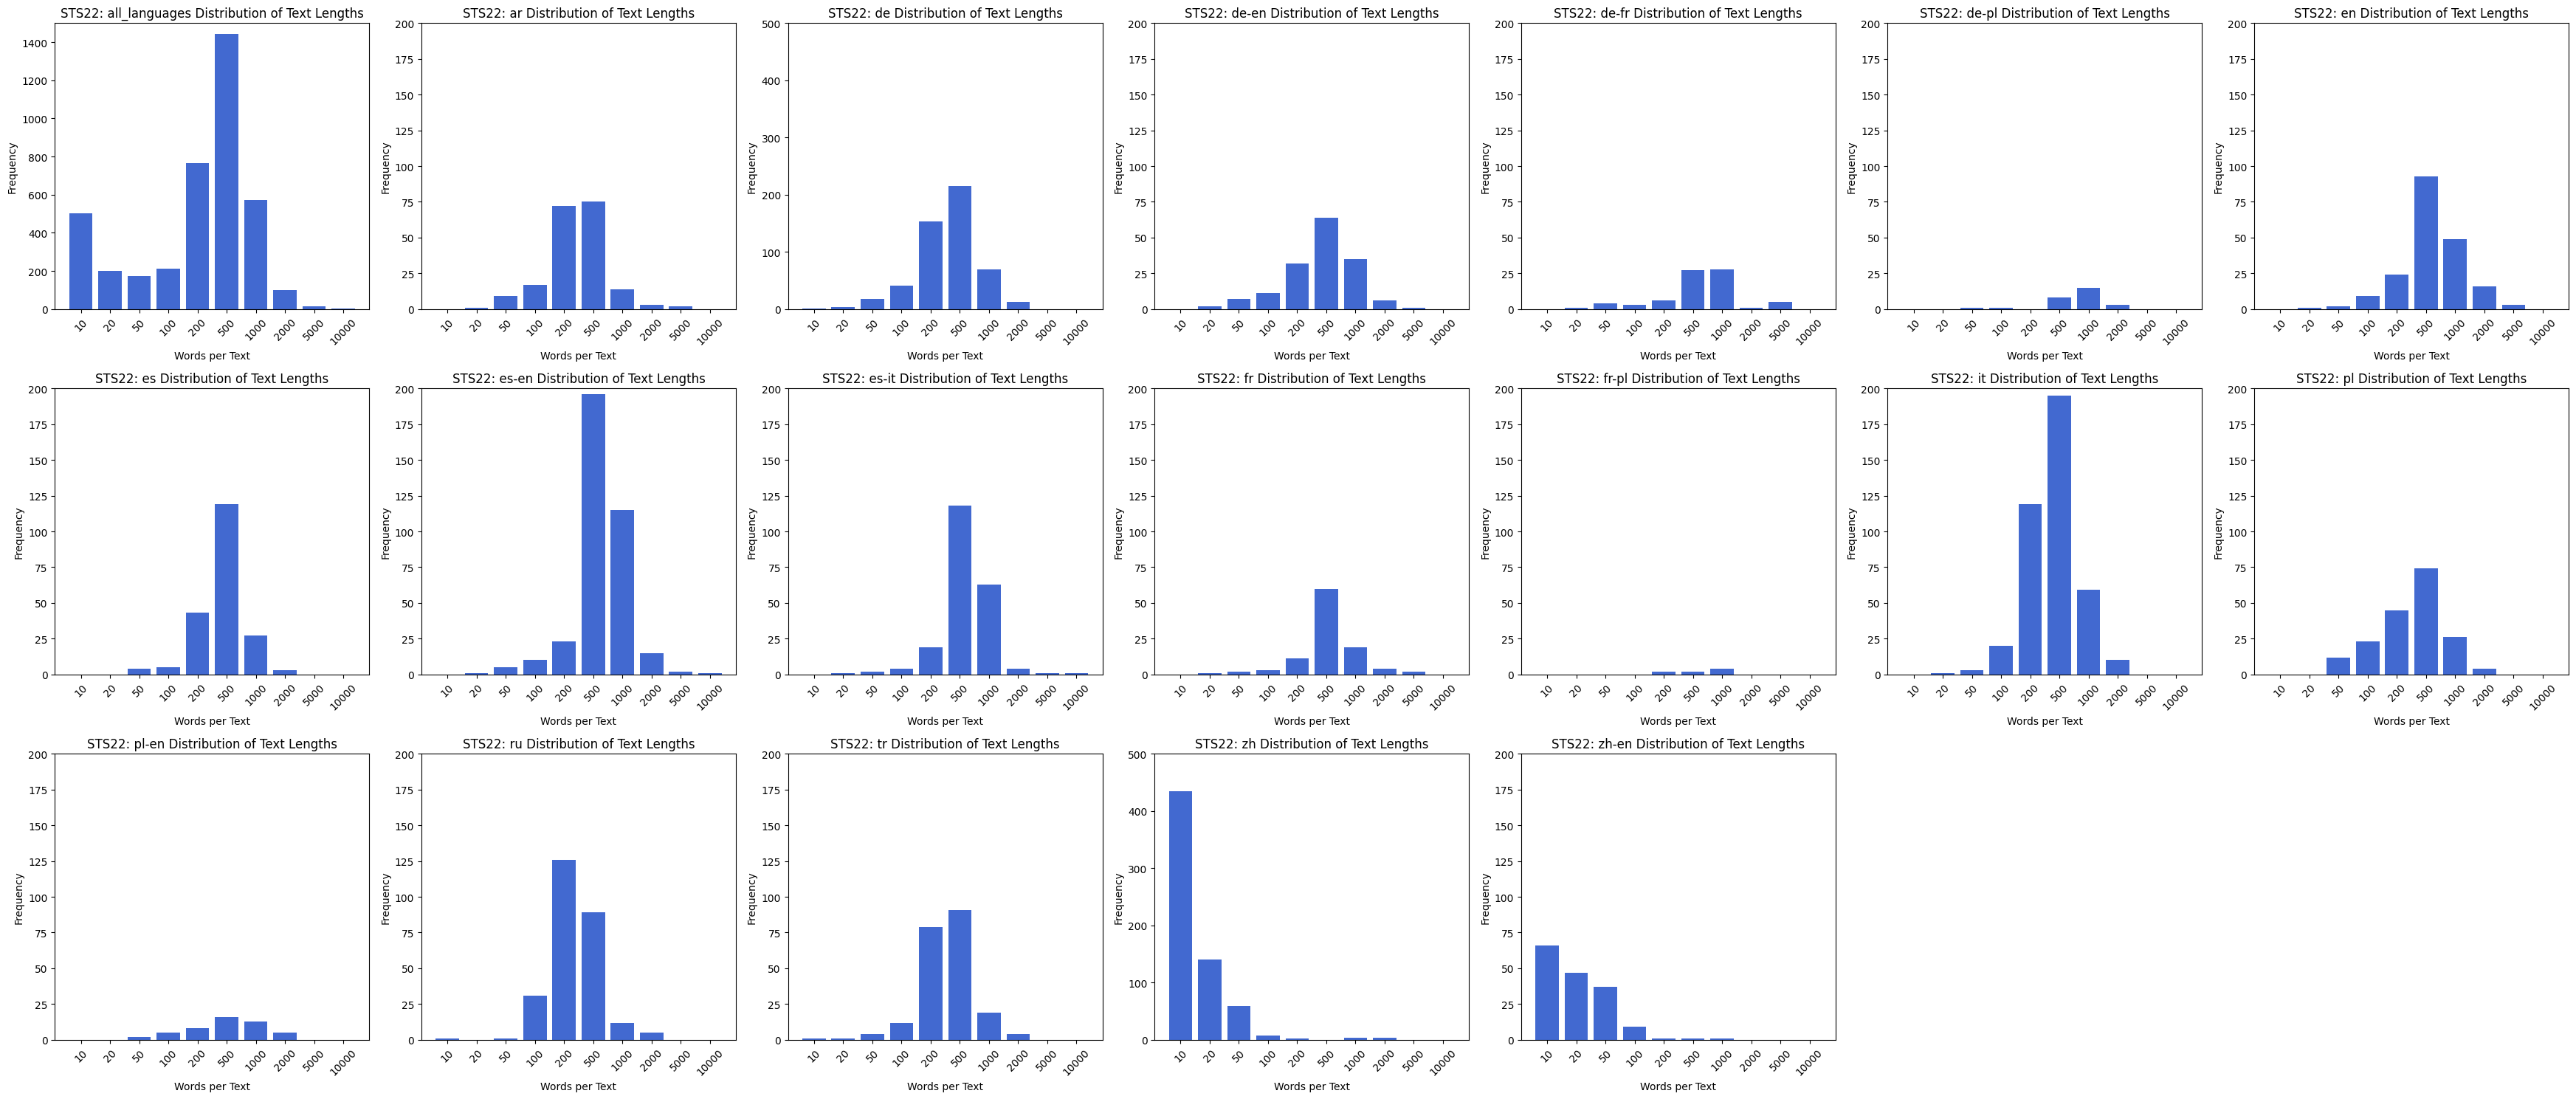

In [9]:
BINS = [0, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
SUBSETS = subsets
createPlts(sts22, SUBSETS, BINS, "plots/sts/sts22_language_distribution.png")

## Result Evaluation

In [10]:
models = [
  "jinaai/jina-embeddings-v2-base-en",
  "thenlper/gte-base",
  "intfloat/multilingual-e5-base"
]

SUBSETS = ["all_languages"]
BINS = [0, 10, 20, 50, 100, 200, 500, 1000, 2000]

In [11]:
samples = {}
for subset in SUBSETS:
    samples_subset = {}
    for idx in range(len(BINS)-1):
        key = f"{BINS[idx]}-{BINS[idx+1]}"
        samples_subset[key] = [InputExample(texts=[item["sentence1"], item["sentence2"]], label=item["score"]/5) for item in sts22[subset] if BINS[idx] <= len(item["sentence1"].split()) < BINS[idx+1]]
    samples[subset] = samples_subset

In [13]:
evaluators = {}

for subset in SUBSETS:
    evaluators_subset = {}
    samples_subset = samples[subset]
    for i in range(len(BINS)-1):
        key = f"{BINS[i]}-{BINS[i+1]}"

        # if there are less than 2 samples, skip this bin
        if samples_subset[key] is None or len(samples_subset[key]) < 2:
            continue

        evaluators_subset[key] = EmbeddingSimilarityEvaluator.from_input_examples(samples_subset[key], name=f"sts22-{key}", batch_size=1)
    evaluators[subset] = evaluators_subset

In [14]:
for model_name in models:
  for subset in evaluators:
    file_paths = []
    extracted_data = {'Range': [], 'cosine_spearman': [], 'Sample Count': []}
    for key in evaluators[subset]:
      model_name = model_name.replace("/", "_")
      file_path = f"results/sts/sts22-{subset}/{model_name}/similarity_evaluation_sts22-{key}_results.csv"
      file_paths.append(file_path)

      df = pd.read_csv(file_path)
      # get last row
      cosine_spearman = df['cosine_spearman'].iloc[-1]
      extracted_data['Range'].append(key)
      extracted_data['cosine_spearman'].append(cosine_spearman)
      extracted_data['Sample Count'].append(len(samples[subset][key]))
    extracted_df = pd.DataFrame(extracted_data)
    print("Model", model_name)
    print("Subset", subset)
    print(extracted_df)


Model jinaai_jina-embeddings-v2-base-en
Subset all_languages
       Range  cosine_spearman  Sample Count
0       0-10         0.392373           513
1      10-20         0.477145           226
2      20-50         0.443652           178
3     50-100         0.163841           208
4    100-200         0.278988           764
5    200-500         0.407489          1447
6   500-1000         0.456179           575
7  1000-2000         0.316588            99
Model thenlper_gte-base
Subset all_languages
       Range  cosine_spearman  Sample Count
0       0-10         0.452733           513
1      10-20         0.517374           226
2      20-50         0.503146           178
3     50-100         0.256616           208
4    100-200         0.466734           764
5    200-500         0.556184          1447
6   500-1000         0.519288           575
7  1000-2000         0.462181            99
Model intfloat_multilingual-e5-base
Subset all_languages
       Range  cosine_spearman  Sample Count
0

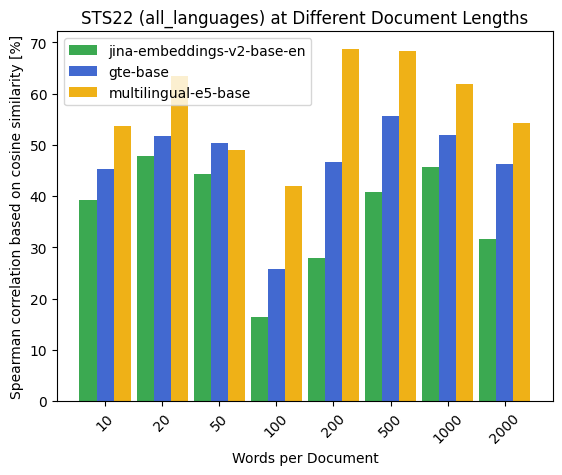

In [15]:
# Data for plotting
chunk_sizes = ["10", "20", "50", "100", "200", "500", "1000", "2000"]
scores_jina = [39.2373, 47.7145, 44.3652, 16.3841, 27.8988, 40.7489, 45.6179, 31.6588]
scores_gte = [45.2733, 51.7374, 50.3146, 25.6616, 46.6734, 55.6184, 51.9288, 46.2181]
scores_intfloat = [53.6147, 63.3634, 48.9680, 41.9932, 68.6960, 68.2654, 61.7828, 54.2578]


# Setting the positions and width for the bars
positions = np.arange(len(chunk_sizes))
width = 0.3  # the width of the bars

# Plotting both the bar charts side by side
plt.bar(positions - width, scores_jina, width, label='jina-embeddings-v2-base-en', color='#3BA951')
plt.bar(positions, scores_gte, width, label='gte-base', color='#4269D0')
plt.bar(positions + width, scores_intfloat, width, label='multilingual-e5-base', color='#EFB117')

plt.legend()

plt.xlabel('Words per Document')
plt.ylabel('Spearman correlation based on cosine similarity [%]')
plt.title('STS22 (all_languages) at Different Document Lengths')
plt.xticks(positions, chunk_sizes)
plt.xticks(rotation=45)

plt.rcParams["font.family"] = "Inter"

# higher resolution output without saving the file
plt.savefig('plots/sts/sts22_spearman_word_count.png', dpi=300, bbox_inches="tight")

# Show the plot
plt.show()
